In [1]:
pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# from zipfile import ZipFile

In [5]:
# dataset_zip_path = "/content/drive/MyDrive/Colab Notebooks/Dataset.zip"

In [6]:
# with ZipFile(dataset_zip_path, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()

#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall()
#     print('Done!')

In [2]:
Datadirectory = "Dataset/train"

In [3]:
Classes = ["angry","disgust","fear","happy","neutral","sad","surprise"] ## list of classes => exact name of folders

In [4]:
# training_Data = []

# def create_training_data():
#     for category in Classes:
#         path = os.path.join(Datadirectory, category)
#         class_num = Classes.index(category)
#         for img in os.listdir(path):
#             try:
#                 img_array = cv2.imread(os.path.join(path,img))
#                 new_array = cv2.resize(img_array,(img_size,img_size))
#                 training_Data.append([new_array,class_num])
#             except Exception as e:
#                 pass

from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )

batch_size = 32

train_image_gen = image_gen.flow_from_directory('Dataset/train',
                                               target_size=(224,224),
                                               batch_size = batch_size,
                                               class_mode='binary')


Found 28709 images belonging to 7 classes.


In [10]:
len(train_image_gen)


898

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

In [6]:
model = tf.keras.applications.MobileNetV2()

In [7]:
# img_size = 224
# X = []  # data/features
# Y = []  # label

# for features,label in training_Data:
#     X.append(features)
#     Y.append(label)


# X = np.array(X).reshape(-1, img_size,img_size,3)



In [8]:
base_input = model.layers[0].input

In [9]:
base_output = model.layers[-2].output

In [10]:
from tensorflow.keras import regularizers

# layer = layers.Dense(
#     units=64,
# )


# final_output = layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
#                             bias_regularizer=regularizers.L2(0.3),
#                              activity_regularizer=regularizers.L2(0.1))(base_output)

# final_output = layers.Activation('relu')(final_output)

# final_output = layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
#                 bias_regularizer=regularizers.L2(0.3),
#                 activity_regularizer=regularizers.L2(0.1))(final_output)

# final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7,activation='softmax')(base_output)
custom_model = Model(inputs=base_input, outputs=final_output)
custom_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [11]:


test_image_gen = image_gen.flow_from_directory('Dataset/test',
                                               target_size=(224,224),
                                               batch_size = batch_size,
                                               class_mode='binary')

Found 7178 images belonging to 7 classes.


In [12]:
train_image_gen.class_indices
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [18]:
resume = True

checkpoint_filepath = 'FER_MODEL/checkpoint'
if resume:
  custom_model.load_weights(checkpoint_filepath)
  print("Resuming the model with best weights...")


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=0,
    mode="auto",
    cooldown=0,
    min_lr=0.00001,
)
results =custom_model.fit(train_image_gen,epochs=5,steps_per_epoch=898,
                            validation_data=test_image_gen,
                            validation_steps=224,callbacks=[model_checkpoint_callback, reduce_lr])


# The model weights (that are considered the best) are loaded into the
# model.
# custom_model.load_weights(checkpoint_filepath)



Resuming the model with best weights...
Epoch 1/5
898/898 [==============================] - 311s 343ms/step - loss: 0.4467 - accuracy: 0.8331 - val_loss: 0.9700 - val_accuracy: 0.6934 - lr: 1.0000e-05
Epoch 2/5
898/898 [==============================] - 228s 254ms/step - loss: 0.4481 - accuracy: 0.8341 - val_loss: 0.9822 - val_accuracy: 0.6844 - lr: 1.0000e-05
Epoch 3/5
898/898 [==============================] - 244s 272ms/step - loss: 0.4481 - accuracy: 0.8351 - val_loss: 0.9862 - val_accuracy: 0.6886 - lr: 1.0000e-05
Epoch 4/5
898/898 [==============================] - 285s 317ms/step - loss: 0.4468 - accuracy: 0.8344 - val_loss: 0.9845 - val_accuracy: 0.6848 - lr: 1.0000e-05
Epoch 5/5
898/898 [==============================] - 249s 277ms/step - loss: 0.4436 - accuracy: 0.8354 - val_loss: 1.0019 - val_accuracy: 0.6900 - lr: 1.0000e-05


In [19]:
custom_model.save("Final_model_001.h5")

In [20]:
new_model = tf.keras.models.load_model("Final_model_001.h5")

In [47]:
testing_image = cv2.imread("angry_face.jpg")

In [48]:
testing_image.shape


(4160, 6240, 3)

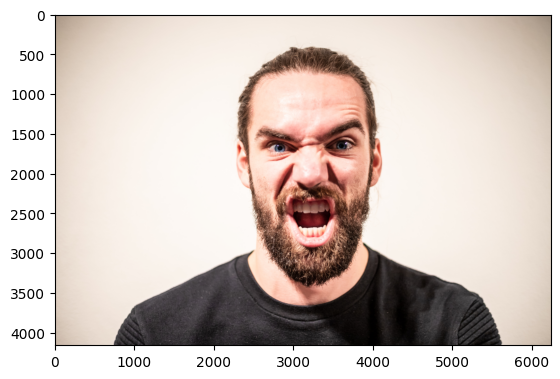

In [49]:
plt.imshow(cv2.cvtColor(testing_image,cv2.COLOR_BGR2RGB))

In [50]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [51]:
gray = cv2.cvtColor(testing_image,cv2.COLOR_RGB2GRAY)

In [52]:
gray.shape

(4160, 6240)

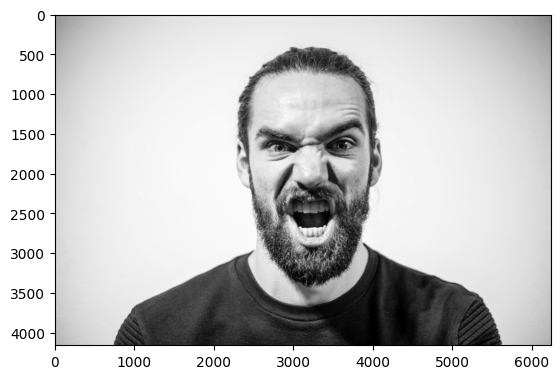

In [53]:
plt.imshow(gray,cmap='gray')

[[2165  838 2060 2060]
 [2832 3728   62   62]]
[[ 144  121 1774 1774]]
()
Face not detected


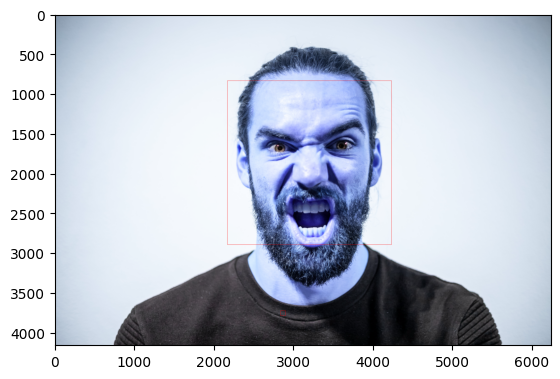

In [54]:
faces = faceCascade.detectMultiScale(gray,1.1,4)

print(faces)

for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x: x+w]
    plt.imshow(roi_gray,cmap='gray')
    roi_color = testing_image[y:y+h, x: x+w]
    plt.imshow(roi_color)
    cv2.rectangle(testing_image, (x,y), (x+w,y+h), (255,0,0), 2)
    plt.imshow(testing_image)

    facess = faceCascade.detectMultiScale(roi_gray)
    print(facess)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for(ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

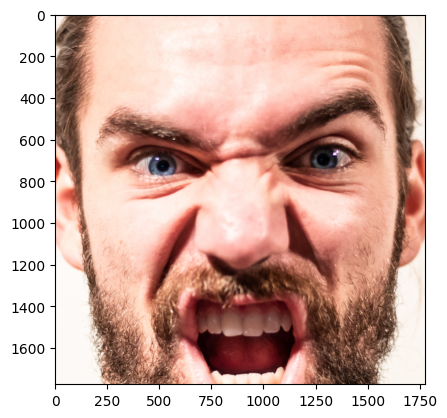

In [55]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [56]:
final_image = cv2.resize(face_roi, (224,224))
final_image = np.expand_dims(final_image,axis = 0)
final_image = final_image/255.0

In [57]:
Predictions = new_model.predict(final_image)

1/1 [==============================] - 0s 254ms/step


In [60]:
Predictions[0]

array([3.0036625e-01, 1.2045008e-05, 6.9854814e-01, 2.3437644e-05,
       3.2172238e-06, 6.1252457e-04, 4.3445063e-04], dtype=float32)

In [2]:

# Data
step_values = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
    31, 32, 33, 34, 35, 36, 37, 38, 39, 40
]

loss_values = [
    1.1496, 1.1011, 1.0541, 1.0273, 1.0012, 0.9822, 0.8922, 0.8621, 0.8467, 0.8237,
    0.8105, 0.7923, 0.7750, 0.7599, 0.6926, 0.6671, 0.6541, 0.6315, 0.6204, 0.5747,
    0.5544, 0.5435, 0.5281, 0.5057, 0.4896, 0.4725, 0.4706, 0.4596, 0.4580, 0.4578,
    0.4554, 0.4571, 0.4516, 0.4478, 0.4468, 0.4490, 0.4449, 0.4431, 0.4416, 0.4468
]

val_loss_values = [
    3.4036, 2.2221, 1.9609, 1.6535, 1.7511, 2.4382, 1.1514, 1.0105, 0.9738, 0.9726,
    1.0211, 0.9603, 0.9673, 1.0139, 0.9211, 0.9308, 0.9093, 0.9774, 0.9562, 0.9239,
    0.9063, 0.9195, 0.9158, 0.9262, 0.9449, 0.9461, 0.9558, 0.9639, 0.9457, 0.9749,
    0.9626, 0.9814, 0.9679, 0.9625, 0.9722, 0.9729, 0.9794, 0.9758, 0.9837, 0.9772
]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the loss values
ax.plot(step_values, loss_values, label='Loss', marker='o')

# Plot the validation loss values
ax.plot(step_values, val_loss_values, label='Validation Loss', marker='x')

# Set y-axis limits to 0 to 1
ax.set_ylim(0, 5)

# Set the x-axis ticks to show every 2 steps
ax.set_xticks(np.arange(0, 41, step=2))

# Add labels and legend
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_title('Training Loss and Validation Loss')
ax.legend()

# Show the plot
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined